# Optimisation of planing -- modification of pyomo models

In this document you can learn to get into the optimisation problem in order to mimic
 what is  defined functions/f_planingModels.py and create your own model.

* [1. Case without storage](#1.withoutStorage)
    * [1.1. Definition of a new model with pyomo](#withoutStorage1)
    * [1.2. Optimisation with the new model](#withoutStorage2)
* [2. Addition of storage](#2.withstorage)
    * [2.1. Coupling of storage optimisation with the new model](#withstorage1)
    * [2.2. Optimisation with the new model and with storage](#withstorage2)


In [1]:
#region importation of modules
import os
if os.path.basename(os.getcwd())=="BasicFunctionalities":
    os.chdir('..') ## to work at project root  like in any IDE

import numpy as np
import pandas as pd
import qgrid # great package https://github.com/quantopian/qgrid
import csv

import datetime
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import linear_model
import sys

from functions.f_operationModels import *
from functions.f_optimization import *
from functions.f_graphicalTools import *
#endregion

#region Solver and data location definition
InputFolder='Data/input/'
if sys.platform != 'win32':
    myhost = os.uname()[1]
else : myhost = ""
if (myhost=="jupyter-sop"):
    ## for https://jupyter-sop.mines-paristech.fr/ users, you need to
    #  (1) run the following to loanch the license server
    if (os.system("/opt/mosek/9.2/tools/platform/linux64x86/bin/lmgrd -c /opt/mosek/9.2/tools/platform/linux64x86/bin/mosek.lic -l lmgrd.log")==0):
        os.system("/opt/mosek/9.2/tools/platform/linux64x86/bin/lmutil lmstat -c 27007@127.0.0.1 -a")
    #  (2) definition of license
    os.environ["MOSEKLM_LICENSE_FILE"] = '@jupyter-sop'


BaseSolverPath='/Users/robin.girard/Documents/Code/Packages/solvers/ampl_macosx64' ### change this to the folder with knitro ampl ...
## in order to obtain more solver see see https://ampl.com/products/solvers/open-source/
## for eduction this site provides also several professional solvers, that are more efficient than e.g. cbc
sys.path.append(BaseSolverPath)
solvers= ['gurobi','knitro','cbc'] # try 'glpk', 'cplex'
solverpath= {}
for solver in solvers : solverpath[solver]=BaseSolverPath+'/'+solver
solver= 'mosek' ## no need for solverpath with mosek.
#endregion


# 1. Case without storage <a class="anchor" id="withoutStorage"></a>

## 1.1 Definition of a new model with pyomo <a class="anchor" id="withoutStorage1"></a>


In the function below the optimisation model is defined, you can modify it. For now
it is exactly a copy of GetElectricSystemModel_PlaningSingleNode.


In [2]:
def My_GetElectricSystemModel_PlaningSingleNode(areaConsumption,availabilityFactor,TechParameters,ConsoTechParameters,ConsoH2,isAbstract=False):

    import pandas as pd
    import numpy as np
    #isAbstract=False
    availabilityFactor.isna().sum()
    ro = 0.7
    NuH2 = 0.5
    ### Cleaning
    availabilityFactor=availabilityFactor.fillna(method='pad');
    areaConsumption=areaConsumption.fillna(method='pad');

    ### obtaining dimensions values
    TECHNOLOGIES=   set(TechParameters.index.get_level_values('TECHNOLOGIES').unique())
    TIMESTAMP=      set(areaConsumption.index.get_level_values('TIMESTAMP').unique())
    TIMESTAMP_list= areaConsumption.index.get_level_values('TIMESTAMP').unique()
    CONSUMPTIONTECHNOLOGIES= set(ConsoTechParameters.index.get_level_values('CONSUMPTIONTECHNOLOGIES').unique())
    #####################
    #    Pyomo model    #
    #####################

    if (isAbstract) :
        model = AbstractModel()
    else:
        model = ConcreteModel()

    ###############
    # Sets       ##
    ###############
    model.TECHNOLOGIES = Set(initialize=TECHNOLOGIES,ordered=False)
    model.TIMESTAMP = Set(initialize=TIMESTAMP,ordered=False)
    model.TIMESTAMP_TECHNOLOGIES =  model.TIMESTAMP *model.TECHNOLOGIES
    model.CONSUMPTIONTECHNOLOGIES = Set(initialize=CONSUMPTIONTECHNOLOGIES,ordered=False)
    model.TIMESTAMP_CONSUMPTIONTECHNOLOGIES = model.TIMESTAMP *model.CONSUMPTIONTECHNOLOGIES
    
    #Subset of Simple only required if ramp constraint
    model.TIMESTAMP_MinusOne = Set(initialize=TIMESTAMP_list[: len(TIMESTAMP) - 1],ordered=False)
    model.TIMESTAMP_MinusThree = Set(initialize=TIMESTAMP_list[: len(TIMESTAMP) - 3],ordered=False)


    ###############
    # Parameters ##
    ###############
    
    model.ConsoH2 = Param(model.TIMESTAMP, mutable=True,
                                      initialize=ConsoH2.loc[:,"ConsoH2"].squeeze().to_dict(), domain=Any)
    
    model.areaConsumption =     Param(model.TIMESTAMP, mutable=True,
                                      initialize=areaConsumption.loc[:,"areaConsumption"].squeeze().to_dict(), domain=Any)
    model.availabilityFactor =  Param(model.TIMESTAMP_TECHNOLOGIES, domain=PercentFraction,default=1,
                                      initialize=availabilityFactor.loc[:,"availabilityFactor"].squeeze().to_dict())
    #with test of existing columns on TechParameters
    
    for COLNAME in TechParameters:
        if COLNAME not in ["TECHNOLOGIES","AREAS"]: ### each column in TechParameters will be a parameter
            exec("model."+COLNAME+" =          Param(model.TECHNOLOGIES, domain=NonNegativeReals,default=0,"+
                                      "initialize=TechParameters."+COLNAME+".squeeze().to_dict())")
    
    for COLNAME in ConsoTechParameters:
        if COLNAME not in ["CONSUMPTIONTECHNOLOGIES"]:
            exec("model."+COLNAME+" =          Param(model.CONSUMPTIONTECHNOLOGIES, domain=NonNegativeReals,default=0,"+
                                      "initialize=ConsoTechParameters."+COLNAME+".squeeze())")
    
    ## manière générique d'écrire pour toutes les colomnes COL de TechParameters quelque chose comme
    # model.COLNAME =          Param(model.TECHNOLOGIES, domain=NonNegativeReals,default=0,
    #                                  initialize=TechParameters.set_index([ "TECHNOLOGIES"]).COLNAME.squeeze().to_dict())

    ################
    # Variables    #
    ################
    model.capacityC=Var(model.CONSUMPTIONTECHNOLOGIES, domain=NonNegativeReals)
    model.capacityCcosts=Var(model.CONSUMPTIONTECHNOLOGIES) 
    model.energyC=Var(model.TIMESTAMP,model.CONSUMPTIONTECHNOLOGIES,domain=NonNegativeReals)
    model.energy=Var(model.TIMESTAMP, model.TECHNOLOGIES, domain=NonNegativeReals) ### Energy produced by a production mean at time t
    model.energyCosts=Var(model.TECHNOLOGIES)  ### Cost of energy for a production mean, explicitely defined by definition energyCostsDef
    model.capacityCosts=Var(model.TECHNOLOGIES)  ### Cost of energy for a production mean, explicitely defined by definition energyCostsDef
    model.capacity=Var(model.TECHNOLOGIES, domain=NonNegativeReals) ### Energy produced by a production mean at time t

    model.dual = Suffix(direction=Suffix.IMPORT)
    model.rc = Suffix(direction=Suffix.IMPORT)
    model.slack = Suffix(direction=Suffix.IMPORT)

    ########################
    # Objective Function   #
    ########################

    def ObjectiveFunction_rule(model): #OBJ
    	return sum(model.energyCosts[tech]+model.capacityCosts[tech] for tech in model.TECHNOLOGIES) + sum(model.capacityCcosts[Ctech] for Ctech in model.CONSUMPTIONTECHNOLOGIES)
    model.OBJ = Objective(rule=ObjectiveFunction_rule, sense=minimize)


    #################
    # Constraints   #
    #################


    # energyCosts definition Constraints
    def energyCostsDef_rule(model,tech): #EQ forall tech in TECHNOLOGIES   energyCosts  = sum{t in TIMESTAMP} energyCost[tech]*energy[t,tech] / 1E6;
        temp=model.energyCost[tech]#/10**6 ;
        return sum(temp*model.energy[t,tech] for t in model.TIMESTAMP) == model.energyCosts[tech]
    model.energyCostsCtr = Constraint(model.TECHNOLOGIES, rule=energyCostsDef_rule)

    # capacityCosts definition Constraints
    def capacityCostsDef_rule(model,tech): #EQ forall tech in TECHNOLOGIES   energyCosts  = sum{t in TIMESTAMP} energyCost[tech]*energy[t,tech] / 1E6;
        temp=model.capacityCost[tech]#/10**6 ;
        return model.capacityCost[tech]*model.capacity[tech] == model.capacityCosts[tech]
        #return model.capacityCost[tech] * len(model.TIMESTAMP) / 8760 * model.capacity[tech] / 10 ** 6 == model.capacityCosts[tech]
    model.capacityCostsCtr = Constraint(model.TECHNOLOGIES, rule=capacityCostsDef_rule)
    
    def capacityCcostsDef_rule(model,Ctech):
        temp=model.capacityCcost[Ctech]
        return(temp*model.capacityC[Ctech] == model.capacityCcosts[Ctech])
    model.capacityCcostsCtr = Constraint(model.CONSUMPTIONTECHNOLOGIES, rule=capacityCcostsDef_rule)



    #Capacity constraint
    def Capacity_rule(model,t,tech): #INEQ forall t, tech
    	return model.capacity[tech] * model.availabilityFactor[t,tech] >= model.energy[t,tech]
    model.CapacityCtr = Constraint(model.TIMESTAMP,model.TECHNOLOGIES, rule=Capacity_rule)

    #contrainte de stock annuel


    #contrainte d'equilibre offre demande
    def energyCtr_rule(model,t): #INEQ forall t
    	return sum(model.energy[t,tech] for tech in model.TECHNOLOGIES ) >= model.areaConsumption[t] + sum(model.energyC[t,Ctech] for Ctech in model.CONSUMPTIONTECHNOLOGIES)
    model.energyCtr = Constraint(model.TIMESTAMP,rule=energyCtr_rule)
    
    consommation = sum(model.ConsoH2[t] for t in model.TIMESTAMP)
    
    def energyCCtr_rule(model,Ctech):
        return sum(ro*model.energyC[t,Ctech] for t in model.TIMESTAMP) >= consommation
    model.energyCCtr = Constraint(model.CONSUMPTIONTECHNOLOGIES,rule=energyCCtr_rule)
    
    def avaibilityC_rule(model,t,Ctech):
        return model.capacityC[Ctech] >= model.energyC[t,Ctech]
    model.avaibilityC = Constraint(model.TIMESTAMP,model.CONSUMPTIONTECHNOLOGIES, rule=avaibilityC_rule)
    
    #if "pac" in TechParameters["TECHNOLOGIES"]:
    def combustion_hydrogene_rule(model):
        return sum(model.energy[t,"pac"] for t in model.TIMESTAMP) <= NuH2*(sum(ro*model.energyC[t,"hydrogene"] for t in model.TIMESTAMP)-consommation)
    model.combustion_hydrogene = Constraint(rule=combustion_hydrogene_rule)
    
    if "maxCapacity" in TechParameters:
        def maxCapacity_rule(model,tech) : #INEQ forall t, tech
            if model.maxCapacity[tech]>0 :
                return model.maxCapacity[tech] >= model.capacity[tech]
            else:
                return Constraint.Skip
        model.maxCapacityCtr = Constraint(model.TECHNOLOGIES, rule=maxCapacity_rule)

    if "minCapacity" in TechParameters:
        def minCapacity_rule(model,tech) : #INEQ forall t, tech
            if model.minCapacity[tech]>0 :
                return model.minCapacity[tech] <= model.capacity[tech]
            else:
                return Constraint.Skip
        model.minCapacityCtr = Constraint(model.TECHNOLOGIES, rule=minCapacity_rule)

    if "EnergyNbhourCap" in TechParameters:
        def storage_rule(model,tech) : #INEQ forall t, tech
            if model.EnergyNbhourCap[tech]>0 :
                return model.EnergyNbhourCap[tech]*model.capacity[tech] >= sum(model.energy[t,tech] for t in model.TIMESTAMP)
            else:
                return Constraint.Skip
        model.storageCtr = Constraint(model.TECHNOLOGIES, rule=storage_rule)

    if "RampConstraintPlus" in TechParameters:
        def rampCtrPlus_rule(model,t,tech): #INEQ forall t<
            if model.RampConstraintPlus[tech]>0 :
                return model.energy[t+1,tech]  - model.energy[t,tech] <= model.capacity[tech]*model.RampConstraintPlus[tech] ;
            else:
                return Constraint.Skip
        model.rampCtrPlus = Constraint(model.TIMESTAMP_MinusOne,model.TECHNOLOGIES,rule=rampCtrPlus_rule)

    if "RampConstraintMoins" in TechParameters:
        def rampCtrMoins_rule(model,t,tech): #INEQ forall t<
            if model.RampConstraintMoins[tech]>0 :
                return model.energy[t+1,tech]  - model.energy[t,tech] >= - model.capacity[tech]*model.RampConstraintMoins[tech] ;
            else:
                return Constraint.Skip
        model.rampCtrMoins = Constraint(model.TIMESTAMP_MinusOne,model.TECHNOLOGIES,rule=rampCtrMoins_rule)

    if "RampConstraintPlus2" in TechParameters:
        def rampCtrPlus2_rule(model,t,tech): #INEQ forall t<
            if model.RampConstraintPlus2[tech]>0 :
                var=(model.energy[t+2,tech]+model.energy[t+3,tech])/2 -  (model.energy[t+1,tech]+model.energy[t,tech])/2;
                return var <= model.capacity[tech]*model.RampConstraintPlus[tech] ;
            else:
                return Constraint.Skip
        model.rampCtrPlus2 = Constraint(model.TIMESTAMP_MinusThree,model.TECHNOLOGIES,rule=rampCtrPlus2_rule)

    if "RampConstraintMoins2" in TechParameters:
        def rampCtrMoins2_rule(model,t,tech): #INEQ forall t<
            if model.RampConstraintMoins2[tech]>0 :
                var=(model.energy[t+2,tech]+model.energy[t+3,tech])/2 -  (model.energy[t+1,tech]+model.energy[t,tech])/2;
                return var >= - model.capacity[tech]*model.RampConstraintMoins2[tech] ;
            else:
                return Constraint.Skip
        model.rampCtrMoins2 = Constraint(model.TIMESTAMP_MinusThree,model.TECHNOLOGIES,rule=rampCtrMoins2_rule)

    return model ;

## 1.2. Optimisation with the new model <a class="anchor" id="withoutStorage2"></a>

Application to the french dataset

In [17]:
#region II - Ramp Single area : loading parameters loading parameterscase with ramp constraints
Zones="FR"
year=2013
Selected_TECHNOLOGIES=['OldNuke', 'CCG',"curtailment","WindOnShore","WindOffShore","Solar","HydroReservoir","HydroRiver","pac"] #you'll add 'Solar' after
#### reading CSV files
areaConsumption = pd.read_csv(InputFolder+'areaConsumption'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0).set_index(["TIMESTAMP"])
availabilityFactor = pd.read_csv(InputFolder+'availabilityFactor'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0).set_index(["TIMESTAMP","TECHNOLOGIES"])

TechParameters = pd.read_csv(InputFolder+'Planing-RAMP1_TECHNOLOGIES.csv',sep=',',decimal='.',skiprows=0,comment="#").set_index(["TECHNOLOGIES"])

ConsoProd = pd.read_csv(InputFolder+'ConsoH2.csv',sep=',',decimal='.',skiprows=0).set_index(["TIMESTAMP"])
ConsoTechParameters = pd.read_csv(InputFolder+'CapacityH2.csv',sep=',',decimal='.',skiprows=0,comment="#").set_index(["CONSUMPTIONTECHNOLOGIES"])

#### Selection of subset
availabilityFactor=availabilityFactor.loc[(slice(None),Selected_TECHNOLOGIES),:]
TechParameters=TechParameters.loc[Selected_TECHNOLOGIES,:]
TechParameters.loc["OldNuke",'RampConstraintMoins']=0.01 ## a bit strong to put in light the effect
TechParameters.loc["OldNuke",'RampConstraintPlus']=0.02 ## a bit strong to put in light the effect
#endregion

In [18]:
#region II - Ramp Single area : solving and loading results
model = My_GetElectricSystemModel_PlaningSingleNode(areaConsumption,availabilityFactor,TechParameters,ConsoTechParameters,ConsoProd)
opt = SolverFactory(solver)
results=opt.solve(model)
Variables=getVariables_panda_indexed(model)
print(extractCosts(Variables))
print(extractEnergyCapacity(Variables))

#pour avoir la production en KWh de chaque moyen de prod chaque heure
production_df=Variables['energy'].pivot(index="TIMESTAMP",columns='TECHNOLOGIES', values='energy')
productionC_df=Variables['energyC'].pivot(index="TIMESTAMP",columns='CONSUMPTIONTECHNOLOGIES', values='energyC')
### Check sum Prod = Consumption
Delta=(production_df.sum(axis=1) - areaConsumption.areaConsumption);
abs(Delta).max()
#endregion

                Capacity_Milliards_euros  Energy_Milliards_euros
TECHNOLOGIES                                                    
HydroRiver                      1.659679                0.000000
WindOnShore                     1.391288                0.000000
CCG                             1.045764                0.017001
HydroReservoir                  0.246834                0.000000
WindOffShore                    0.000000                0.000000
curtailment                     0.000000               -0.000000
pac                             0.180000                0.000000
Solar                           0.546480                0.000000
OldNuke                        13.894902                1.939014
                Capacity_GW  Production_TWh
TECHNOLOGIES                               
HydroRiver        42.360358    2.067153e+02
WindOnShore       13.410000    2.738125e+01
CCG               10.800000    3.398807e-01
HydroReservoir     6.300000    1.323000e+01
WindOffShore       0.

5051.093299028711

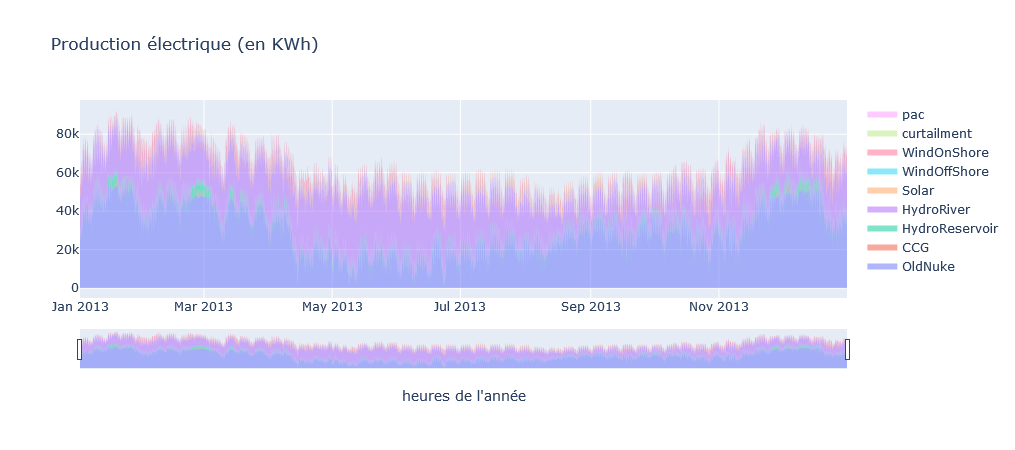

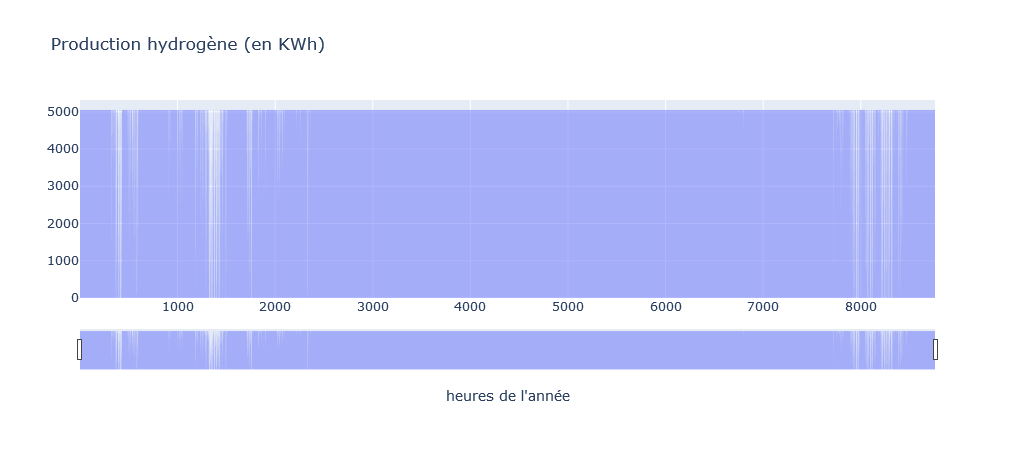

array([-0.])

In [19]:
#region II - Ramp Single area : visualisation and lagrange multipliers
TIMESTAMP_d=pd.date_range(start=str(year)+"-01-01 00:00:00",end=str(year)+"-12-31 23:00:00",   freq="1H")
production_df.index=TIMESTAMP_d; areaConsumption.index=TIMESTAMP_d;
fig=MyStackedPlotly(y_df=production_df,Conso = areaConsumption)
fig=fig.update_layout(title_text="Production électrique (en KWh)", xaxis_title="heures de l'année")
#plotly.offline.plot(fig, filename='file.html') ## offline
fig.show()
fig1=MyStackedPlotly(y_df=productionC_df,Conso = areaConsumption)
fig1=fig1.update_layout(title_text="Production hydrogène (en KWh)", xaxis_title="heures de l'année")
fig1.show()
#### lagrange multipliers
Constraints= getConstraintsDual_panda(model)

# Analyse energyCtr
energyCtrDual=Constraints['energyCtr']; energyCtrDual['energyCtr']=energyCtrDual['energyCtr']*1000000
energyCtrDual
round(energyCtrDual.energyCtr,2).unique()

# Analyse CapacityCtr
CapacityCtrDual=Constraints['CapacityCtr'].pivot(index="TIMESTAMP",columns='TECHNOLOGIES', values='CapacityCtr')*1000000;
round(CapacityCtrDual,2)
round(CapacityCtrDual.OldNuke,2).unique() ## if you increase by Delta the installed capacity of nuke you decrease by xxx the cost when nuke is not sufficient
round(CapacityCtrDual.CCG,2).unique() ## increasing the capacity of CCG as no effect on prices
#endregion

# 2. Addition of storage <a class="anchor" id="2.withstorage"></a>
## 2.1. Coupling of storage optimisation with the new model <a class="anchor" id="withstorage1"></a>

In [ ]:
def My_GetElectricSystemModel_PlaningSingleNode_with1Storage(areaConsumption,availabilityFactor,
                                                          TechParameters,StorageParameters,solverpath=-1,isAbstract=False,
                                                          solver='mosek',n=10,tol=exp(-4)):
    """
    This function takes storage caracteristics, system caracteristics and optimise operation Set values
    :param areaConsumption: panda table with consumption
    :param availabilityFactor: panda table
    :param isAbstract: boolean true is the model should be abstract. ConcreteModel otherwise
    :param StorageParameters is a dictionary with p_max (maximal power), c_max (energy capacity in the storage : maximal energy),
    :efficiency_in (input efficiency of storage),
    :efficiency_out (output efficiency of storage).
    :return: a dictionary with model : pyomo model without storage, storage : storage infos
    """
    import pandas as pd
    import numpy as np
    from dynprogstorage.wrappers import GenCostFunctionFromMarketPrices
    from dynprogstorage.wrappers import GenCostFunctionFromMarketPrices_dict
    #isAbstract=False

    model = My_GetElectricSystemModel_PlaningSingleNode(areaConsumption, availabilityFactor, TechParameters,isAbstract=isAbstract)
    if solverpath==-1 : opt = SolverFactory(solver)
    else : opt = MySolverFactory(solver, solverpath)
   # results = opt.solve(model)
   # Variables = getVariables_panda(model) #### obtain optimized variables in panda form
   # Constraints = getConstraintsDual_panda(model)  #### obtain lagrange multipliers in panda form

    ##### Loop
    PrixTotal = {}
    Consommation = {}
    LMultipliers = {}
    DeltaPrix = {}
    Deltazz = {}
    CostFunction = {}
    TotalCols = {}
    zz = {}
    # p_max_out=100.; p_max_in=100.; c_max=10.;

    areaConsumption["NewConsumption"] = areaConsumption["areaConsumption"]
    nbTime = len(areaConsumption["areaConsumption"])
    cpt = 0
    for i in model.areaConsumption:  model.areaConsumption[i] = areaConsumption.NewConsumption[i]
    DeltaPrix_=tol+1
    while ( (DeltaPrix_ >  tol) & (n>cpt) ) :
        print(cpt)
        if (cpt == 0):
            zz[cpt] = [0] * nbTime
        else:
            zz[cpt] = areaConsumption["Storage"]

        #if solver=="mosek" :
        #    results = opt.solve(model, options= {"dparam.optimizer_max_time":  100.0, "iparam.outlev" : 2,                                                 "iparam.optimizer":     mosek.optimizertype.primal_simplex},tee=True)
        #else :
        if (solver=='cplex')| (solver=='cbc'):
            results = opt.solve(model,warmstart = True)
        else : results = opt.solve(model)

        Constraints = getConstraintsDual_panda(model)
        #if solver=='cbc':
        #    Variables = getVariables_panda(model)['energy'].set_index(['TIMESTAMP','TECHNOLOGIES'])
        #    for i in model.energy:  model.energy[i] = Variables.energy[i]


        TotalCols[cpt] = getVariables_panda(model)['energyCosts'].sum()[1]+getVariables_panda(model)['capacityCosts'].sum()[1]
        Prix = Constraints["energyCtr"].assign(Prix=lambda x: x.energyCtr ).Prix.to_numpy()
        Prix[Prix<=0]=0.0000000001
        valueAtZero =  TotalCols[cpt] - Prix * zz[cpt]
        tmpCost = GenCostFunctionFromMarketPrices_dict(Prix, r_in=StorageParameters['efficiency_in'],
                                                       r_out=StorageParameters['efficiency_out'],
                                                       valueAtZero=valueAtZero)
        if (cpt == 0):
            CostFunction[cpt] = GenCostFunctionFromMarketPrices(Prix, r_in=StorageParameters['efficiency_in'],
                                                                r_out=StorageParameters['efficiency_out'], valueAtZero=valueAtZero)
        else:
            tmpCost = GenCostFunctionFromMarketPrices_dict(Prix, r_in=StorageParameters['efficiency_in'],
                                                           r_out=StorageParameters['efficiency_out'], valueAtZero=valueAtZero)
            tmpCost2 = CostFunction[cpt - 1]
            if StorageParameters['efficiency_in']*StorageParameters['efficiency_out']==1:
                tmpCost2.Maxf_1Breaks_withO(tmpCost['S1'], tmpCost['B1'], tmpCost[
                    'f0'])
            else:
                tmpCost2.Maxf_2Breaks_withO(tmpCost['S1'], tmpCost['S2'], tmpCost['B1'], tmpCost['B2'], tmpCost[
                'f0'])  ### etape clé, il faut bien comprendre ici l'utilisation du max de deux fonction de coût
            CostFunction[cpt] = tmpCost2
        LMultipliers[cpt] = Prix
        if cpt > 0:
            DeltaPrix[cpt] = sum(abs(LMultipliers[cpt] - LMultipliers[cpt - 1]))/sum(abs(LMultipliers[cpt]))
            Deltazz[cpt] = sum(abs(zz[cpt] - zz[cpt - 1]))/sum(abs(zz[cpt]))
            DeltaPrix_= DeltaPrix[cpt]

        areaConsumption.loc[:, "Storage"] = CostFunction[cpt].OptimMargInt([-StorageParameters['p_max']/StorageParameters['efficiency_out']] * nbTime,
                                                                    [StorageParameters['p_max']*StorageParameters['efficiency_in']] * nbTime,
                                                                           [0] * nbTime,
                                                                    [StorageParameters['c_max']] * nbTime)

        areaConsumption.loc[areaConsumption.loc[:, "Storage"]>0, "Storage"]=areaConsumption.loc[areaConsumption.loc[:, "Storage"]>0, "Storage"]/StorageParameters['efficiency_in']
        areaConsumption.loc[areaConsumption.loc[:, "Storage"]<0, "Storage"]=areaConsumption.loc[areaConsumption.loc[:, "Storage"]<0, "Storage"]*StorageParameters['efficiency_out']
        areaConsumption.loc[:,"NewConsumption"] = areaConsumption.loc[:,"areaConsumption"] + areaConsumption.loc[:,"Storage"]
        for i in model.areaConsumption:  model.areaConsumption[i] = areaConsumption.NewConsumption[i]
        cpt=cpt+1

    results = opt.solve(model)
    stats = {"DeltaPrix" : DeltaPrix,"Deltazz" : Deltazz}
    return {"areaConsumption" : areaConsumption, "model" : model, "stats" : stats};


## 2.2. Optimisation with the new model and with storage <a class="anchor" id="withstorage2"></a>


In [ ]:
#region IV Ramp+Storage single area : loading parameters
Zones="FR"
year=2013

Selected_TECHNOLOGIES=['OldNuke','WindOnShore', 'CCG',"curtailment"] ## try adding 'HydroRiver', 'HydroReservoir'

#### reading CSV files
areaConsumption = pd.read_csv(InputFolder+'areaConsumption'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0).set_index(["TIMESTAMP"])
availabilityFactor = pd.read_csv(InputFolder+'availabilityFactor'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0).set_index(["TIMESTAMP","TECHNOLOGIES"])
TechParameters = pd.read_csv(InputFolder+'Planing-RAMP1_TECHNOLOGIES.csv',
                             sep=',',decimal='.',skiprows=0,comment="#").set_index(["TECHNOLOGIES"])


#### Selection of subset
availabilityFactor=availabilityFactor.loc[(slice(None),Selected_TECHNOLOGIES),:]
TechParameters=TechParameters.loc[Selected_TECHNOLOGIES,:]
#TechParameters.loc["CCG",'capacity']=100000 ## margin to make everything work
TechParameters.loc["OldNuke",'RampConstraintMoins']=0.02 ## a bit strong to put in light the effect
TechParameters.loc["OldNuke",'RampConstraintPlus']=0.02 ## a bit strong to put in light the effect
p_max=5000 ### 7 GW de STEP + 10 GW de batteries
StorageParameters={"p_max" : p_max , "c_max": p_max*10,"efficiency_in": 0.9,"efficiency_out" : 0.9}
#endregion

In [ ]:
#region IV Ramp+Storage single area : solving and loading results
res= My_GetElectricSystemModel_PlaningSingleNode_with1Storage(areaConsumption,availabilityFactor,
                                                      TechParameters,StorageParameters)

Variables = getVariables_panda_indexed(res['model'])
Constraints = getConstraintsDual_panda(res['model'])
areaConsumption = res["areaConsumption"]

print(extractCosts(Variables))
print(extractEnergyCapacity(Variables))

production_df=Variables['energy'].pivot(index="TIMESTAMP",columns='TECHNOLOGIES', values='energy')
Delta= production_df.sum(axis=1)-areaConsumption["NewConsumption"]
print(sum(abs(Delta)))
production_df.loc[:,'Storage'] = -areaConsumption["Storage"] ### put storage in the production time series
production_df.sum(axis=0)/10**6 ### energies produites TWh
production_df[production_df>0].sum(axis=0)/10**6 ### energies produites TWh
production_df.max(axis=0)/1000 ### Pmax en GW

TIMESTAMP_d=pd.date_range(start=str(year)+"-01-01 00:00:00",end=str(year)+"-12-31 23:00:00",   freq="1H")
production_df.index=TIMESTAMP_d; areaConsumption.index=TIMESTAMP_d;
fig=MyStackedPlotly(y_df=production_df, Conso=areaConsumption)
fig=fig.update_layout(title_text="Production électrique (en KWh)", xaxis_title="heures de l'année")
#plotly.offline.plot(fig, filename='file.html') ## offline
fig.show()
stats=res["stats"]
#endregion